In [4]:
import pandas as pd
import numpy as np

import torch
from transformers import BertTokenizer, BertConfig, BertModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from dataset import RelationsDS

data = RelationsDS(root='./data').to(device=device)
data[0]

Data(edge_index=[2, 111276], edge_attr=[111276], token_ids=[91294, 147], token_mask=[91294, 147], token_type_ids=[91294, 147])

# BERT encoder

In [10]:
from torch.utils.data import DataLoader

g = data[0].to(device)
tokens = torch.stack([g.token_ids, g.token_mask, g.token_type_ids], dim=1)
tokens.shape

torch.Size([91294, 3, 147])

In [11]:
model = BertModel.from_pretrained('bert-base-uncased').to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [36]:
91294/2, 45647/7

(45647.0, 6521.0)

In [15]:
tokens.shape

torch.Size([91294, 3, 147])

In [19]:
batch_size = 1024
token_loader = DataLoader(tokens, batch_size=batch_size)

encoding_size = 768
x = None

with torch.no_grad():
    for batch_num, token_batch in enumerate(token_loader):
        if batch_num % 10*batch_size == 0:
            print(f'batch {batch_num}/{len(token_loader)}')
        batch_encoding = model(token_batch[:,0,:],
                               token_batch[:,1,:],
                               token_batch[:,2,:]).last_hidden_state[:,0,:]
        if x is None:
            x = batch_encoding
        else:
            x = torch.concat([x, batch_encoding])

batch 0/90
batch 10/90
batch 20/90
batch 30/90
batch 40/90
batch 50/90
batch 60/90
batch 70/90
batch 80/90


In [20]:
x.shape

torch.Size([91294, 768])

In [7]:
with torch.no_grad():
    idx = 0
    id = g.token_ids[idx].unsqueeze(0)
    mask = g.token_mask[idx].unsqueeze(0)
    type_ids = g.token_type_ids[idx].unsqueeze(0)
    print(id.shape, mask.shape, type_ids.shape)

    encoding = model(id, mask, type_ids)

torch.Size([1, 138]) torch.Size([1, 138]) torch.Size([1, 138])


In [5]:
with torch.no_grad():
    num = 10
    id = g.token_ids[:num]
    mask = g.token_mask[:num]
    type_ids = g.token_type_ids[:num]
    print(id.shape, mask.shape, type_ids.shape)

    encoding = model(id, mask, type_ids)

torch.Size([10, 138]) torch.Size([10, 138]) torch.Size([10, 138])


In [10]:
lhs = encoding.last_hidden_state
lhs = lhs[:, 0, :]
lhs = lhs.flatten(start_dim=1)
print(lhs.shape, type(lhs))
print(lhs.mean(), lhs.std())

torch.Size([10, 768]) <class 'torch.Tensor'>
tensor(-0.0102, device='cuda:0') tensor(0.5358, device='cuda:0')


# Model

adapted from [Online Link Prediction with Graph Neural Networks](https://medium.com/stanford-cs224w/online-link-prediction-with-graph-neural-networks-46c1054f2aa4)

In [2]:
from model import Model, LinkPredictor, NodeEmbedder

In [6]:
device = 'cuda'
g = data[0].to(device)
tokens = torch.stack([g.token_ids, g.token_mask, g.token_type_ids], dim=1)

node_embedder = NodeEmbedder(input_dim=768,
                                hidden_dim=256,
                                output_dim=256,
                                num_heads=1,
                                num_layers=2).to(device)
link_pred = LinkPredictor(input_dim=256, 
                            hidden_dim=128,
                            output_dim=1,
                            num_layers=3).to(device)
model = Model(node_embedder, link_pred)

node_encodings = node_embedder.load_input_encodings('data/input_encoding.pt').to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [7]:
from dataset import split_data_stratified
from torch.nn.functional import one_hot
g.x = node_encodings
g = split_data_stratified(g, data.num_nodes) # create neg samples and train/val/test splits 
g.edge_attr = one_hot(g.edge_attr).float()

In [29]:
g.edge_attr

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [64]:
from torch_geometric.nn import GATv2Conv
import torch.nn.functional as F
input_dim=768
hidden_dim=256
output_dim=256
num_heads=2
conv1 = GATv2Conv(input_dim, hidden_dim, num_heads, edge_dim=3, add_self_loops=False).to(device)
conv2 = GATv2Conv(hidden_dim*num_heads, hidden_dim, num_heads, edge_dim=3, add_self_loops=False).to(device)

In [58]:
print(g.x.dtype, g.edge_index.dtype, g.edge_attr.dtype)
print(g.x.shape, g.edge_index.shape, g.edge_attr.shape)

torch.float32 torch.int64 torch.float32
torch.Size([91294, 768]) torch.Size([2, 162510]) torch.Size([162510, 3])


In [68]:
x = g.x
x.dim()

2

In [11]:
g.pos_samples.shape, g.train_mask.max()

(torch.Size([2, 111276]), tensor(111275, device='cuda:0'))

In [65]:
x = conv1(g.x, g.edge_index, g.edge_attr)

In [66]:
x = F.relu(x)

In [50]:
x = conv2(x, g.edge_index, g.edge_attr)

In [52]:
x.shape

torch.Size([91294, 512])

In [12]:
from torch.utils.data import DataLoader
link_loader = DataLoader(g.train_mask,
                         batch_size=1024,
                         shuffle=True)


In [57]:
for l in link_loader:
    print(l.max(), g.pos_samples.shape)
    pos_samples = g.pos
    break

tensor(111274, device='cuda:0') torch.Size([2, 111276])


In [9]:
with torch.no_grad():
    node_embeddings = model.encode_inputs(tokens) 

In [18]:
torch.save(node_embeddings, 'data/input_encodings.pt')

In [6]:
node_embeddings = model.load_input_encodings().to(device)

Data(edge_index=[2, 111276], edge_type=[111276], token_ids=[91294, 147], token_mask=[91294, 147], token_type_ids=[91294, 147])

# Evaluations

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, f1_score, precision_score, recall_score
from sklearn.preprocessing import binarize

In [10]:
res = pd.read_csv('out1-results.csv')
res

,Unnamed: 0,y_true,y_pred
0,0,1.0,4.293613e-03
1,1,1.0,4.131731e-03
2,2,1.0,1.196989e-15
3,3,1.0,3.568706e-01
4,4,1.0,9.985288e-01
...,...,...,...
44507,44507,0.0,5.768935e-37
44508,44508,0.0,6.171165e-14
44509,44509,0.0,1.056769e-04
44510,44510,0.0,0.000000e+00


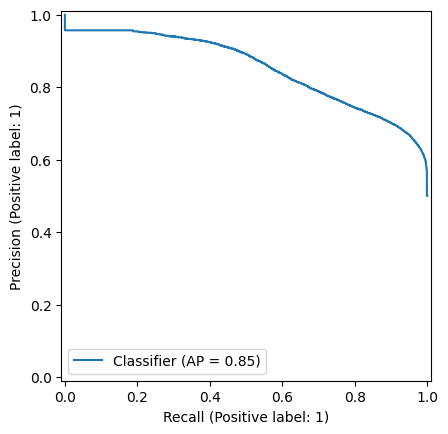

In [11]:
PrecisionRecallDisplay.from_predictions(res['y_true'], res['y_pred'])
plt.show()

In [12]:
res['y_pred_bin'] = binarize(res['y_pred'].to_numpy().reshape((1,-1)), threshold=0.5).flatten()
print(f1_score(res['y_true'], res['y_pred_bin']))
print(precision_score(res['y_true'], res['y_pred_bin']))
print(recall_score(res['y_true'], res['y_pred_bin']))

0.6464744504710248
0.8864098950994207
0.5087616822429907


In [15]:
train = pd.read_csv('out1-train_losses.csv')
train

,epoch,train loss,val loss
0,0,0.727129,0.727039
1,1,0.727039,0.726953
2,2,0.726954,0.726868
3,3,0.726868,0.726778
4,4,0.726778,0.726681
...,...,...,...
995,995,0.544317,0.542323
996,996,0.544300,0.542207
997,997,0.544283,0.542331
998,998,0.544266,0.542133


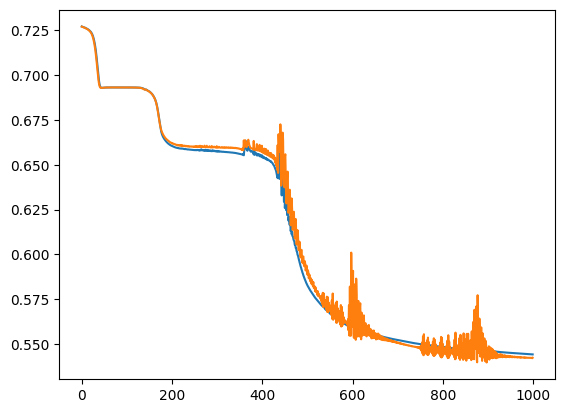

In [16]:
plt.plot(train['epoch'], train['train loss'])
plt.plot(train['epoch'], train['val loss'])
plt.show()